In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## get the data from the checker (only timestamp field) table using sqlite3, the only filter is we need data only of the users and not the admins

In [2]:
con = sqlite3.connect('../data/checking-logs-test-control.sqlite')

In [3]:
df = pd.read_sql('select timestamp from checker where uid like "user_%"', con, parse_dates=['timestamp'])

In [4]:
df.head()

,timestamp
0,2020-04-17 05:19:02.744528
1,2020-04-17 05:22:35.249331
2,2020-04-17 05:22:45.549397
3,2020-04-17 05:34:14.691200
4,2020-04-17 05:34:24.422370


## create a dataframe df with the columns: date, am, pm, target, where date is the date of the day, am is the number of the commits during the day before midday (integer), pm is the number of commits during the day after midday (integer), target is weekend or working_day

In [5]:
df['date'] = df.timestamp.dt.date
df['AM/PM'] = (df.timestamp.dt.hour).apply(lambda x: 'am' if x < 12 else 'pm')
df['target'] = (df.timestamp.dt.dayofweek).apply(lambda x: 'working_day' if x < 5 else 'weekend')
df.head()

,timestamp,date,AM/PM,target
0,2020-04-17 05:19:02.744528,2020-04-17,am,working_day
1,2020-04-17 05:22:35.249331,2020-04-17,am,working_day
2,2020-04-17 05:22:45.549397,2020-04-17,am,working_day
3,2020-04-17 05:34:14.691200,2020-04-17,am,working_day
4,2020-04-17 05:34:24.422370,2020-04-17,am,working_day


In [6]:
df_pivot = pd.pivot_table(data=df, columns='AM/PM', index=['date', 'target'], 
               values='timestamp', aggfunc='count', fill_value=0.0).reset_index().set_index('date')

In [7]:
df_pivot.head()

AM/PM,target,am,pm
date,,,
2020-04-17,working_day,21,2
2020-04-18,weekend,1,68
2020-04-19,weekend,18,15
2020-04-20,working_day,2,23
2020-04-21,working_day,0,25


In [8]:
list(df_pivot.target.unique())

['working_day', 'weekend']

##  create a plot where x is am, y is pm, each dot is a day, working days and weekends must have different colors

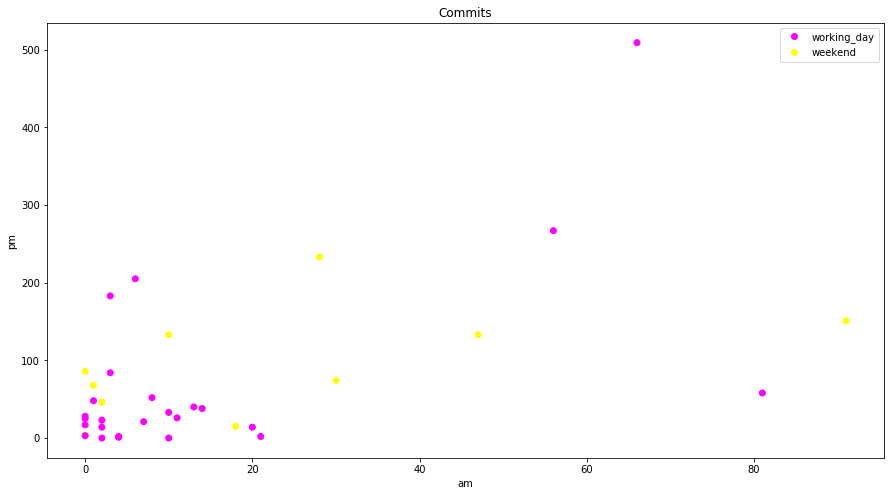

In [20]:
fig, ax = plt.subplots(figsize=(15, 8))
scatter = ax.scatter(x = df_pivot['am'], y=df_pivot['pm'], cmap='spring', 
                      c=[0 if i == 'working_day' else 1 for i in df_pivot.target])

handles, labels = scatter.legend_elements(prop='colors')
ax.legend(handles, ['working_day', 'weekend'])
ax.set_title('Commits')
ax.set_xlabel('am')
ax.set_ylabel('pm')
plt.show()

## by looking at the graph do you think it will be easy to classify the days having those two features? 

no, it is not easy.

##  train logistic regression on your data using am and pm, parameters are: random state=21, fit_intercept=False

In [10]:
X = df_pivot[['am', 'pm']].values
y = df_pivot['target'].values

In [11]:
clf = LogisticRegression(random_state=21, fit_intercept=False).fit(X, y)

##  make predictions for every day of your dataset and add them to your dataframe with the column name predict

In [12]:
y_pred = clf.predict(X)

In [13]:
df_pivot['predict'] = y_pred

In [14]:
df_pivot.head()

AM/PM,target,am,pm,predict
date,,,,
2020-04-17,working_day,21,2,weekend
2020-04-18,weekend,1,68,working_day
2020-04-19,weekend,18,15,working_day
2020-04-20,working_day,2,23,working_day
2020-04-21,working_day,0,25,working_day


##  save the dataframe into a file in the subfolder of the day data with the name am_pm.csv

In [15]:
df_pivot.to_csv('../data/am_pm.csv')

## draw another plot like before, but the color should be taken from the predict

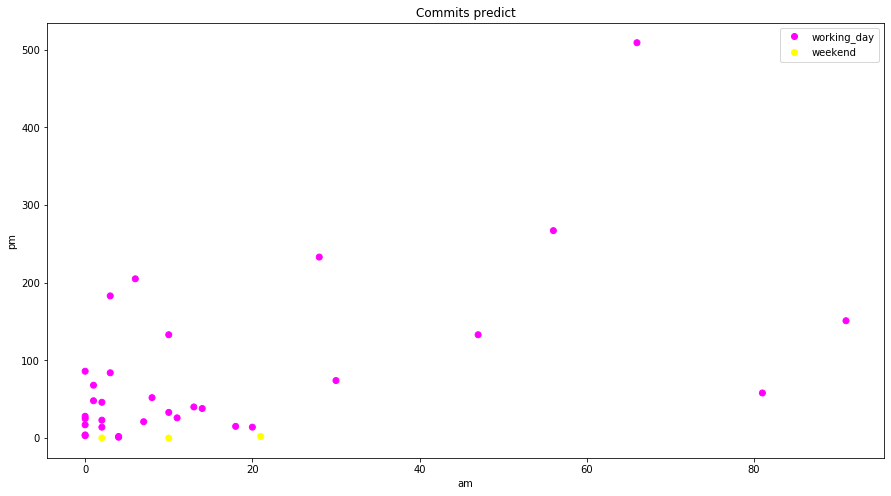

In [16]:
fig, ax = plt.subplots(figsize=(15, 8))
scatter = ax.scatter(x = df_pivot['am'], y=df_pivot['pm'], cmap='spring', 
                      c=[0 if i == 'working_day' else 1 for i in df_pivot.predict])

handles, labels = scatter.legend_elements(prop='colors')
ax.legend(handles, ['working_day', 'weekend'])
ax.set_title('Commits predict')
ax.set_xlabel('am')
ax.set_ylabel('pm')
plt.show()

## by looking at the graph do you think if it made good predictions?

no, it is not good

## calculate accuracy for your predictions

In [17]:
accuracy_score(y, y_pred)

0.6285714285714286

##  calculate accuracy for the naive case when each of your prediction is the value of your most popular class of the day

In [18]:
accuracy_score(y, [df_pivot.target.max()] * len(y))

0.7142857142857143

## by comparing the accuracies do you think that the classifier made good predictions?

no, it is not good

In [19]:
con.close()